In [1]:
import pickle

import nibabel as nib
import torch 

with open('logs/diff-swin-unetr-btcv-1/results.pkl', 'rb') as f:
    results = pickle.load(f)

/home/song99/anaconda3/envs/medsegdiff/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(results.keys())
print(results['dices'])

images = results['images']
dices = results['dices']
outputs = results['outputs']
labels = results['labels']  

dict_keys(['images', 'dices', 'labels', 'outputs'])
[OrderedDict([('spleen', 0.9628888964653015), ('right kidney', 0.9370067119598389), ('left kidney', 0.9414383769035339), ('gall bladder', 1), ('esophagus', 0.70216304063797), ('liver', 0.9679784774780273), ('stomach', 0.8783325552940369), ('arota', 0.9297596216201782), ('IVC', 0.8891321420669556), ('veins', 0.7486756443977356), ('pancreas', 0.7674431204795837), ('right adrenal gland', 0.7365010976791382), ('left adrenal gland', 0.6774616837501526)]), OrderedDict([('spleen', 0.9649627208709717), ('right kidney', 0.964996337890625), ('left kidney', 0.9609116315841675), ('gall bladder', 0.8311966061592102), ('esophagus', 0.8206882476806641), ('liver', 0.9714324474334717), ('stomach', 0.9333065748214722), ('arota', 0.9190351366996765), ('IVC', 0.7955509424209595), ('veins', 0.7602120637893677), ('pancreas', 0.7785524129867554), ('right adrenal gland', 0.7012722492218018), ('left adrenal gland', 0.7308759689331055)]), OrderedDict([('spleen

In [10]:

# cpu_images = []
# cpu_outputs = []
# cpu_labels = []

# for image in images:
#     image = image.cpu()
#     cpu_images.append(image)
    
# for output in outputs:
#     output = output.cpu()
#     cpu_outputs.append(output)
    
# for label in labels:
#     label = label.cpu()
#     cpu_labels.append(label)
    
    
# for image in cpu_images:
#     print(image.shape)
#     print(image.device)
    
# res = {
#     'images': cpu_images,
#     'outputs': cpu_outputs,
#     'labels': cpu_labels,
#     'dices': dices
# }

# with open('logs/diff-swin-unetr-btcv-1/results_cpu.pkl', 'wb') as f:
#     pickle.dump(res, f)

torch.Size([1, 1, 314, 215, 234])
cpu
torch.Size([1, 1, 255, 223, 276])
cpu
torch.Size([1, 1, 238, 203, 246])
cpu
torch.Size([1, 1, 325, 280, 248])
cpu
torch.Size([1, 1, 333, 229, 224])
cpu
torch.Size([1, 1, 254, 210, 292])
cpu


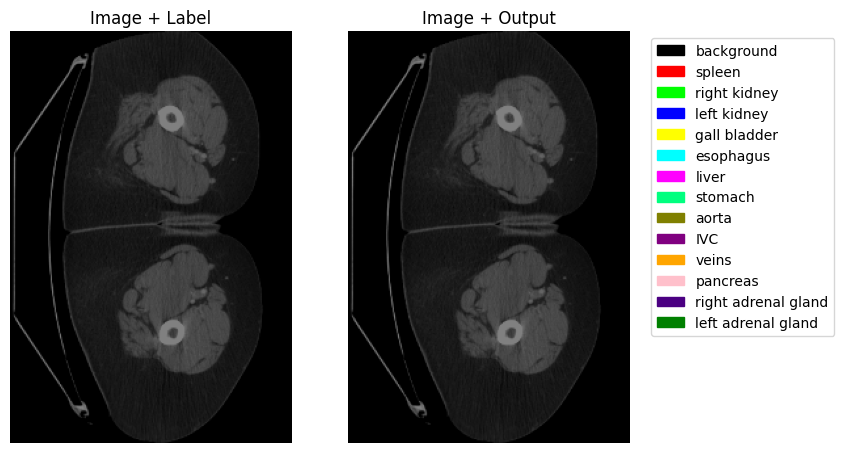

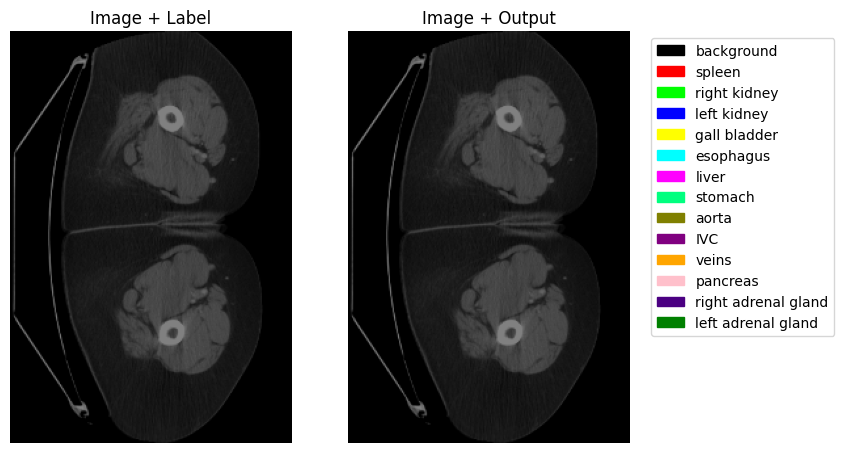

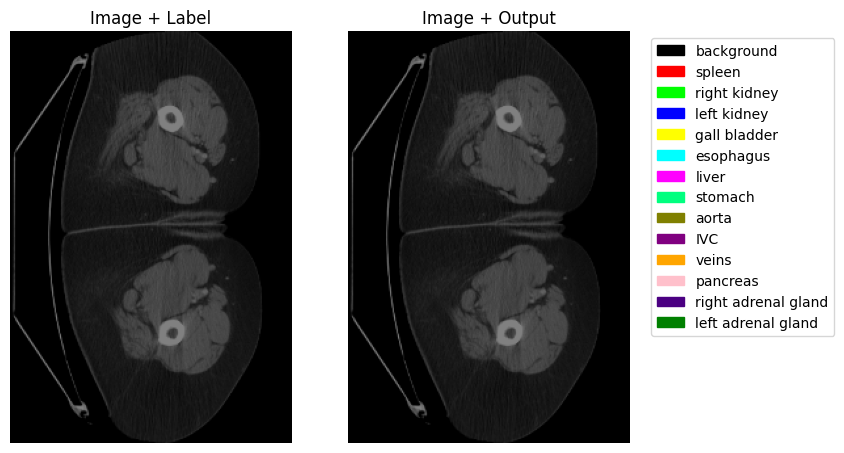

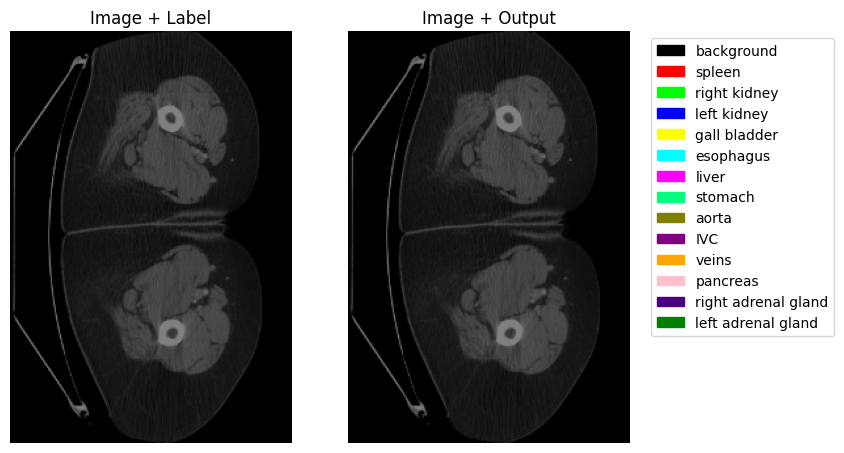

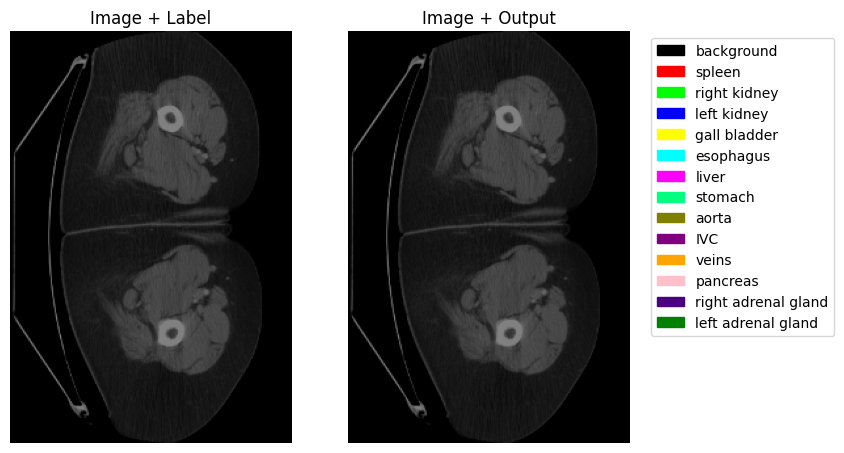

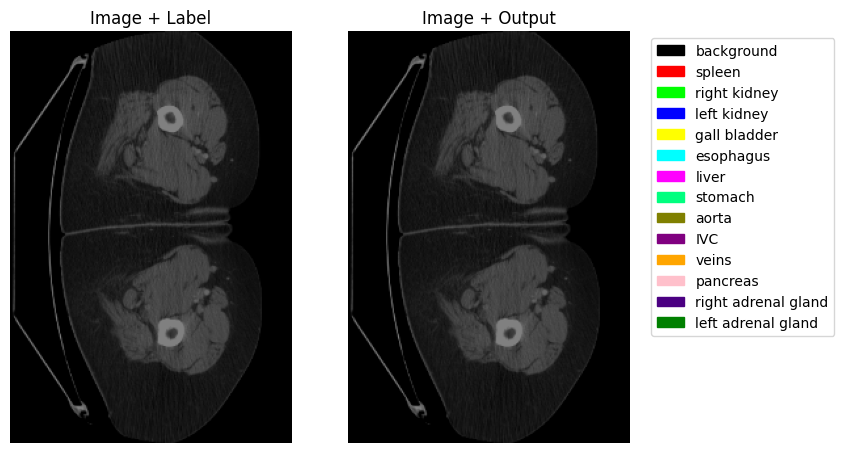

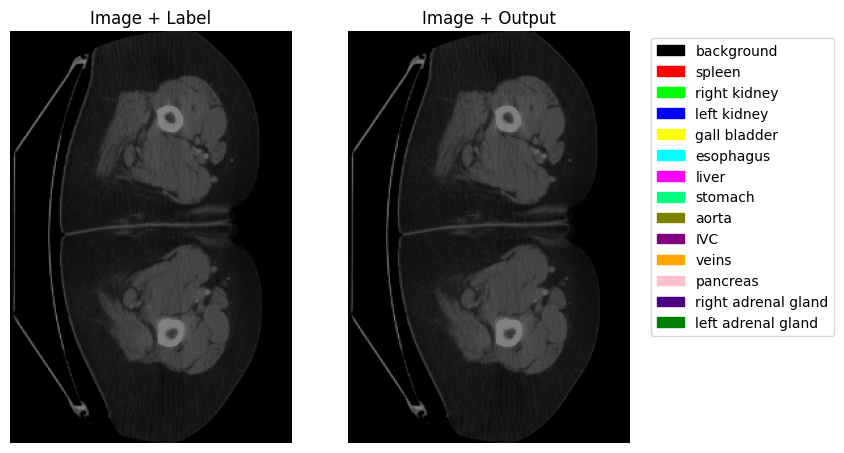

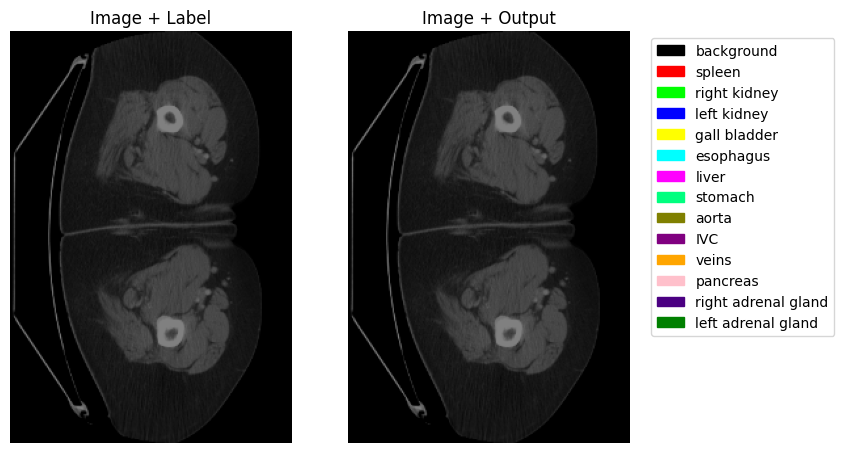

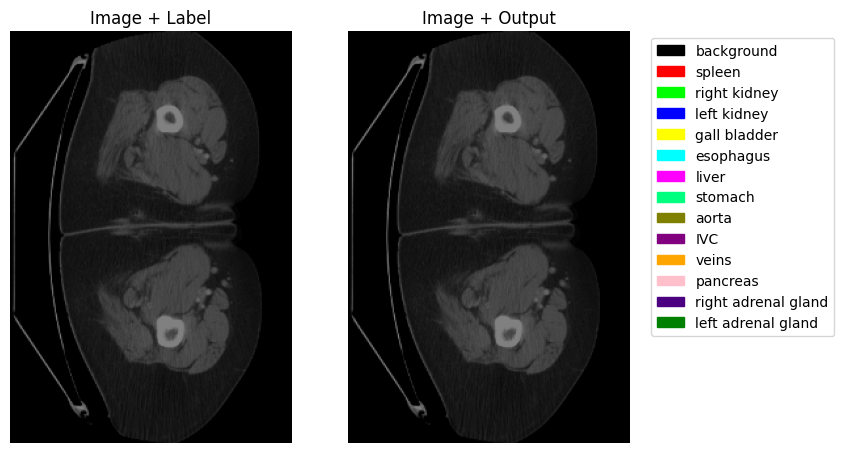

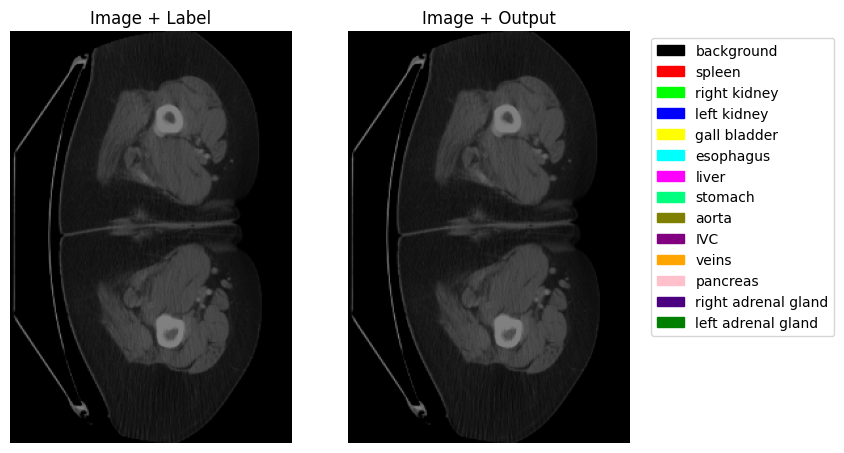

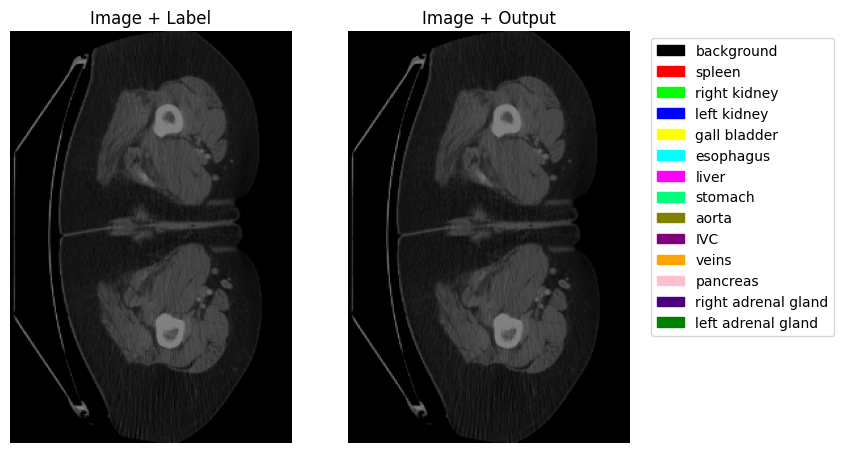

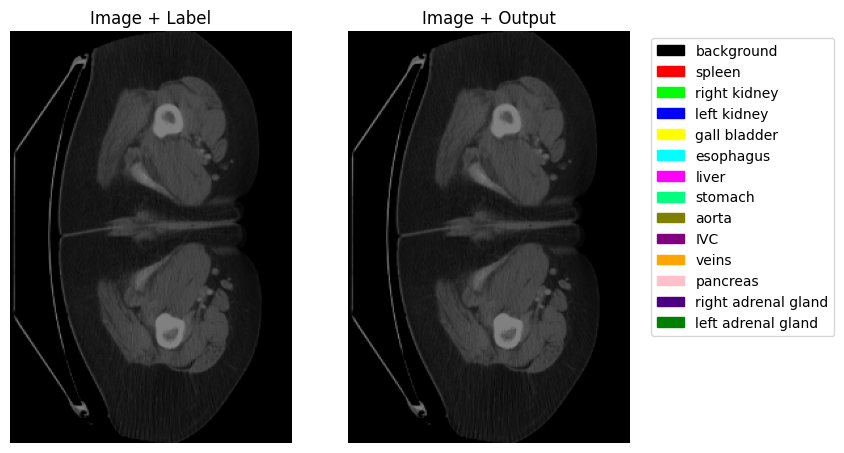

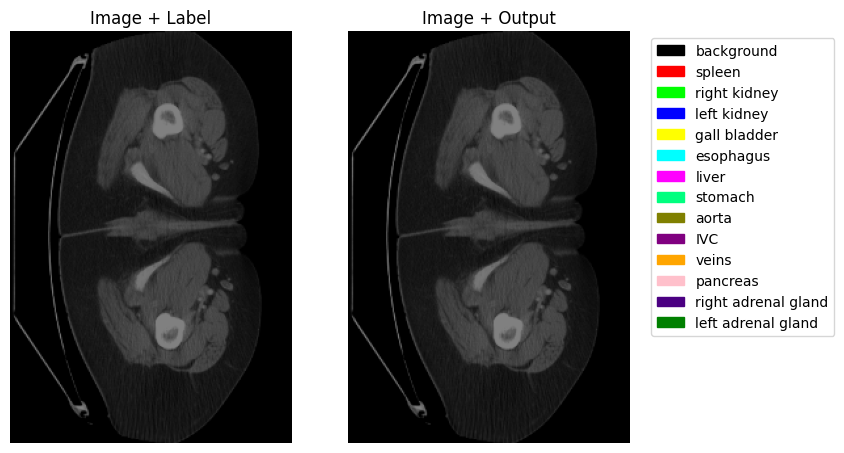

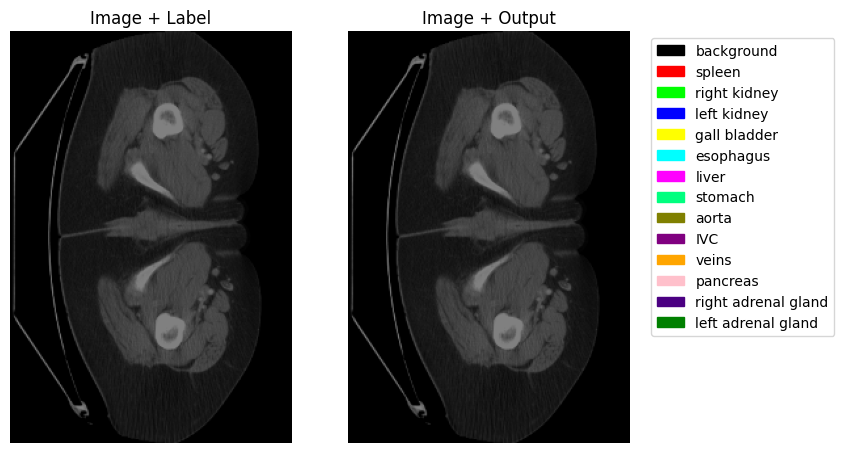

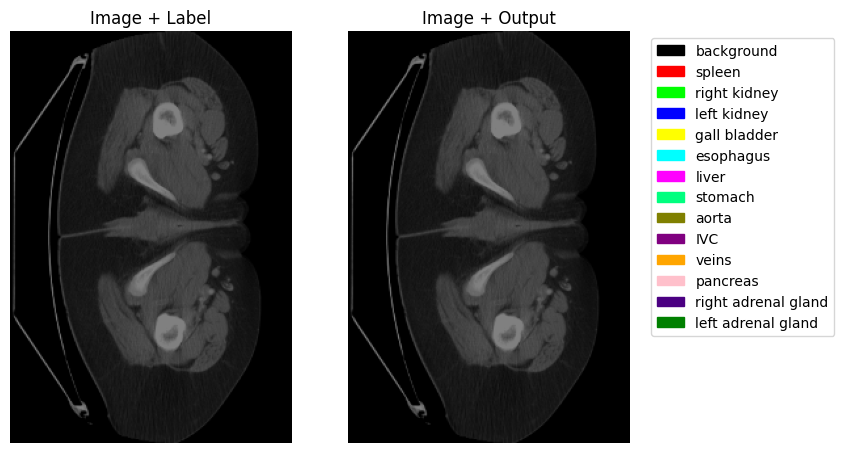

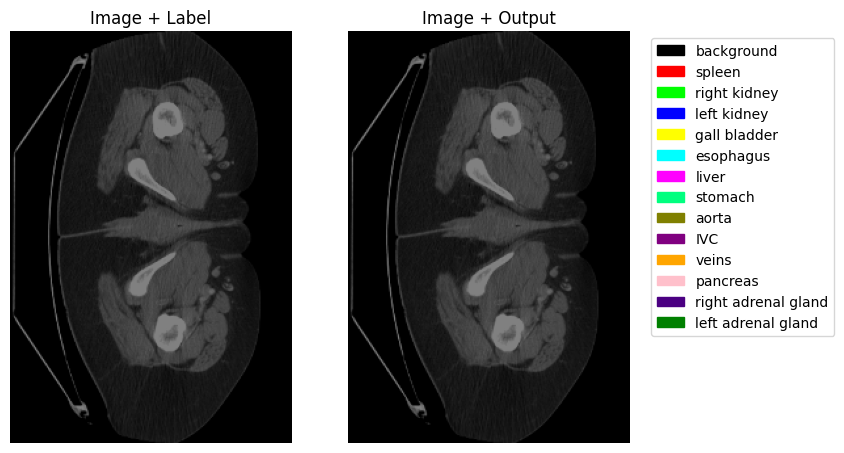

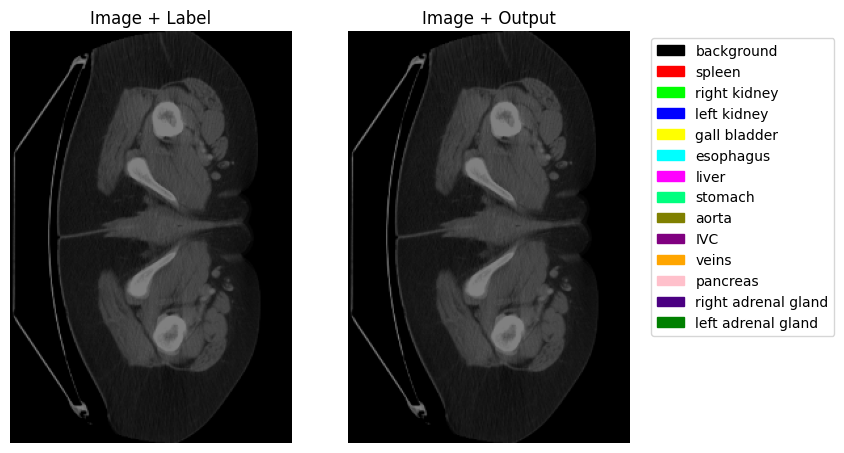

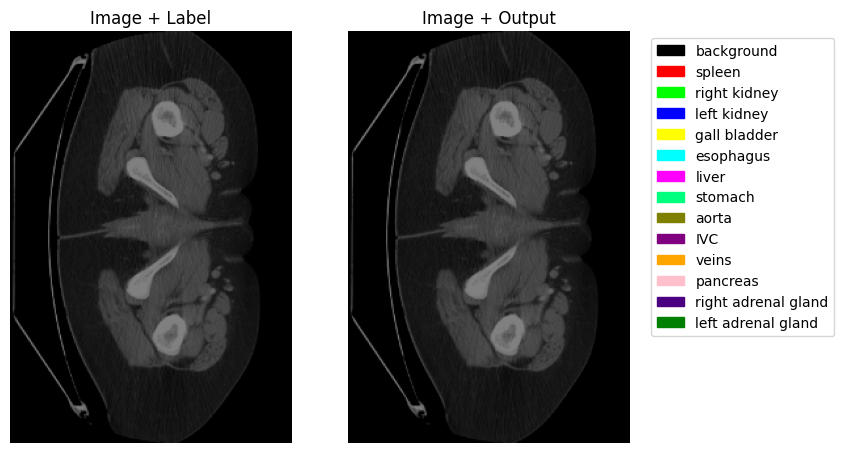

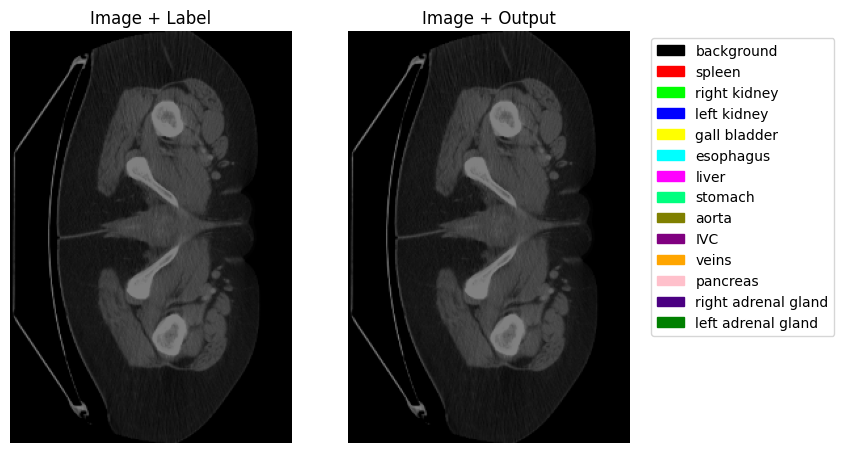

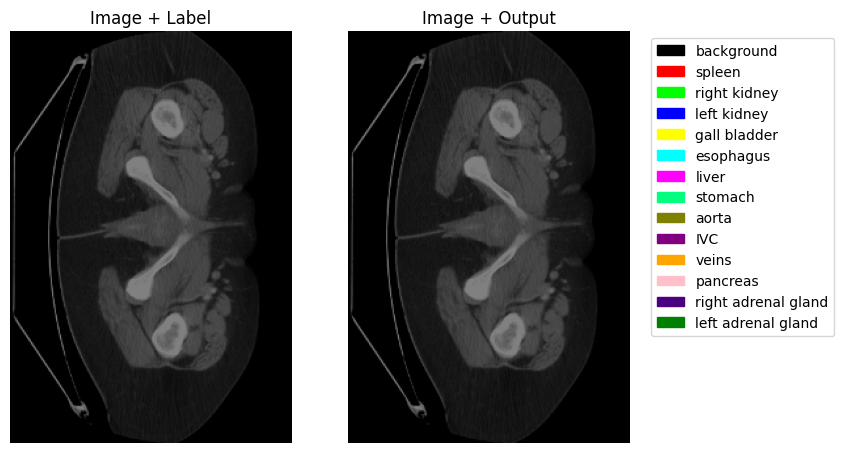

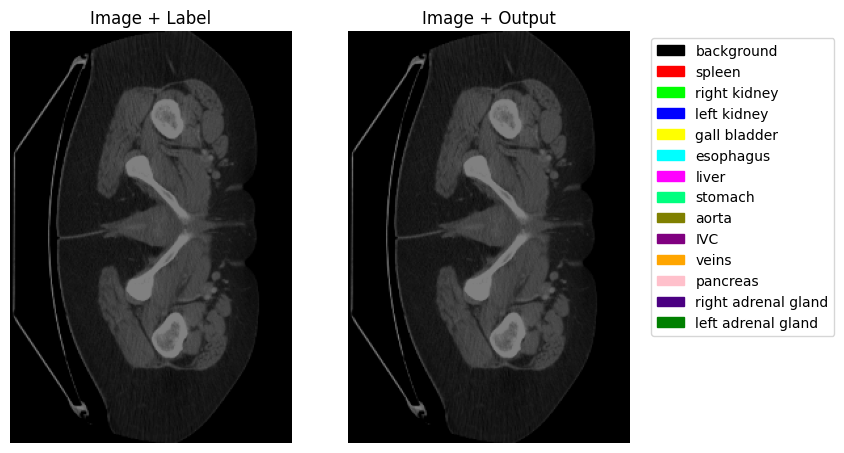

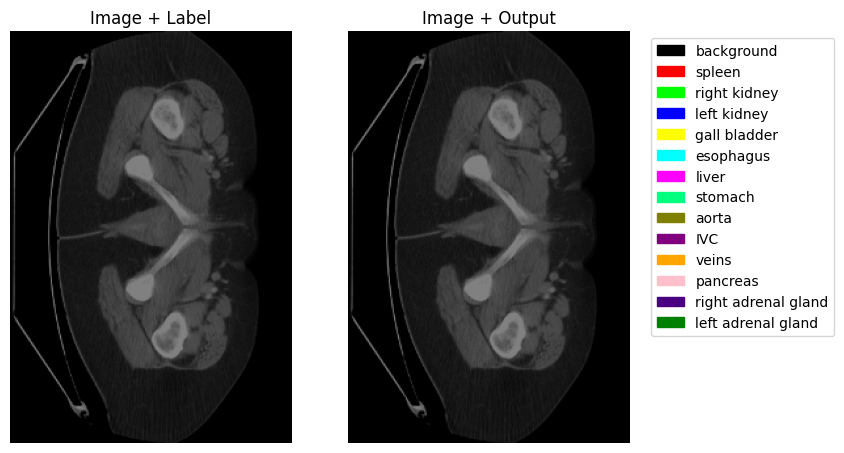

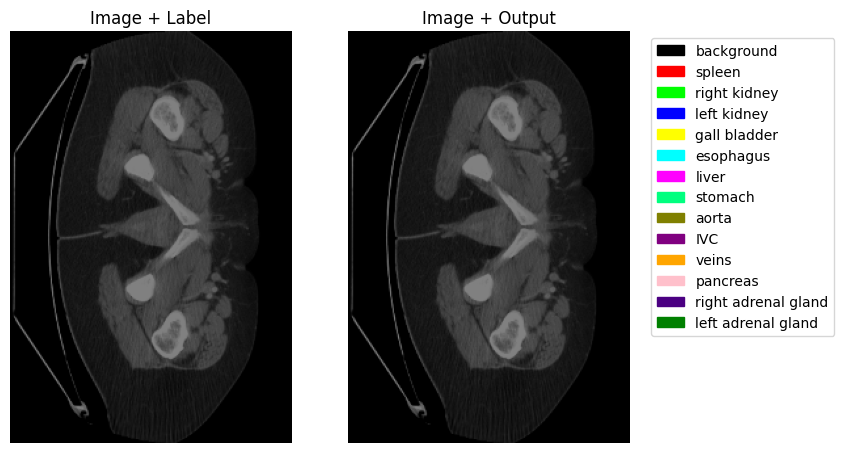

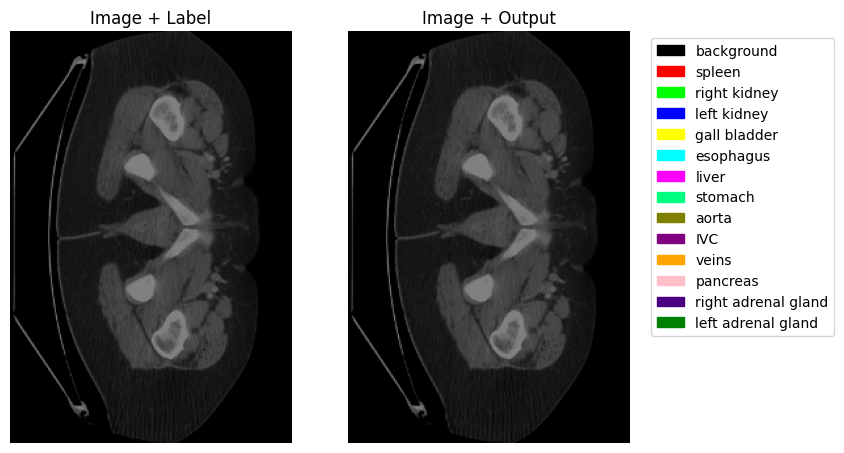

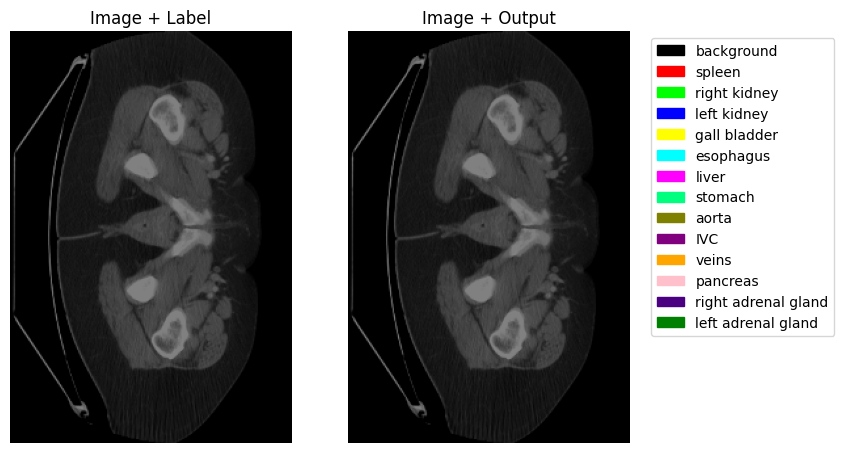

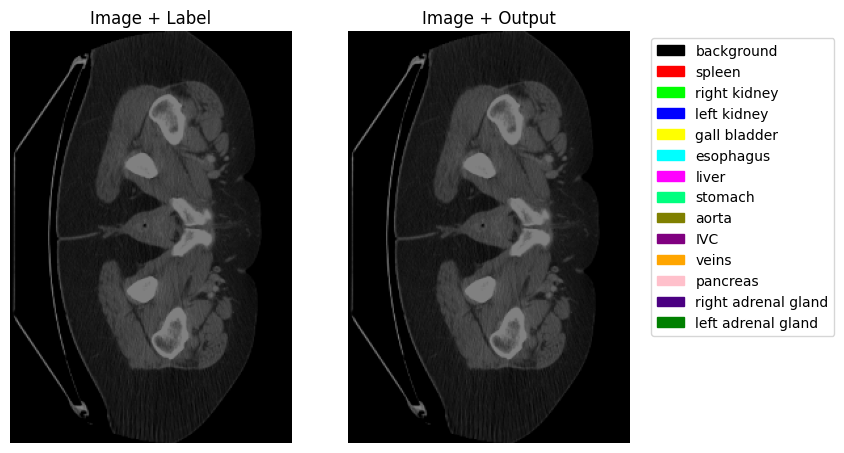

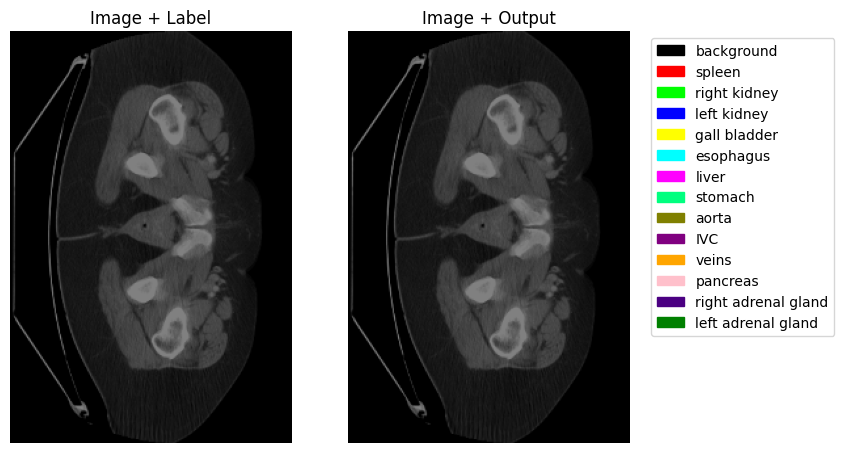

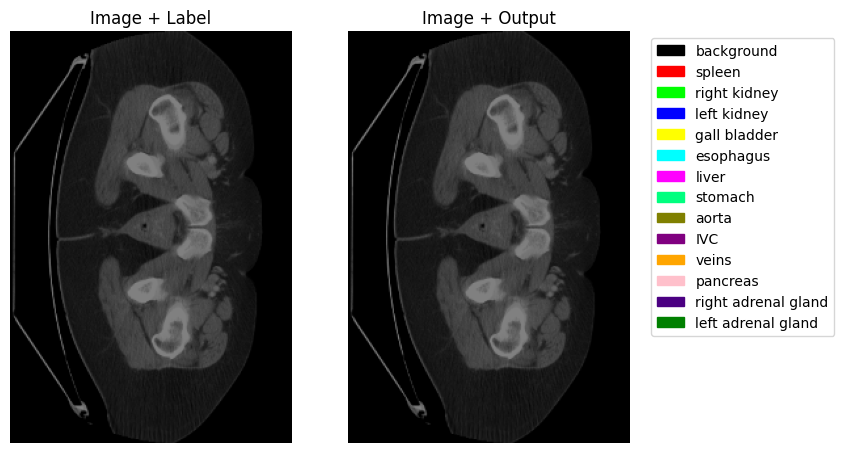

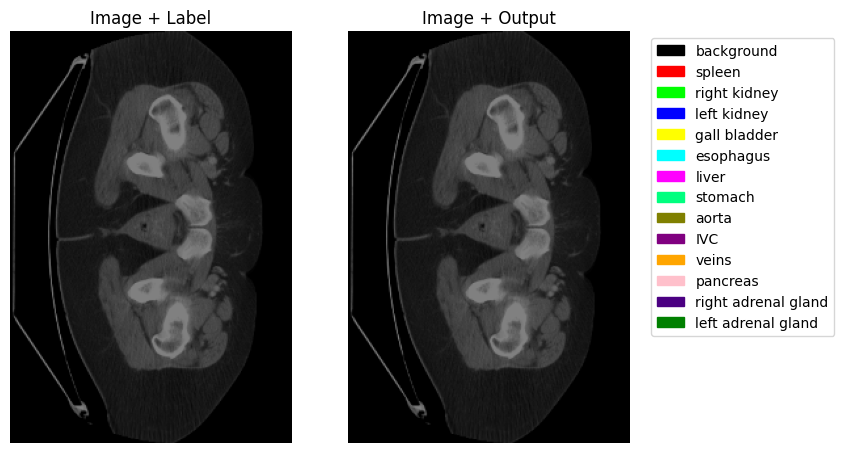

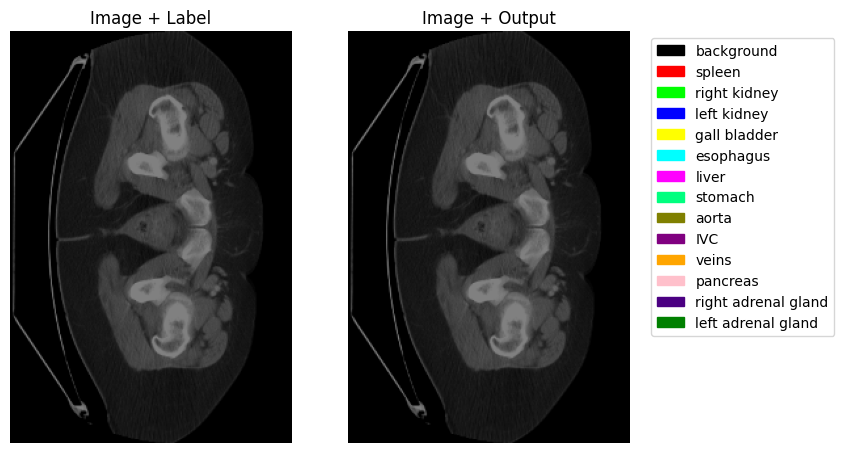

KeyboardInterrupt: 

In [3]:
import os

import wandb

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# 클래스 이름
classes = [
    "background", "spleen", "right kidney", "left kidney", "gall bladder",
    "esophagus", "liver", "stomach", "aorta", "IVC",
    "veins", "pancreas", "right adrenal gland", "left adrenal gland"
]

color_map = {
    0: [0, 0, 0],         # 검은색
    1: [255, 0, 0],       # 빨강
    2: [0, 255, 0],       # 초록
    3: [0, 0, 255],       # 파랑
    4: [255, 255, 0],     # 노랑
    5: [0, 255, 255],     # 청록색
    6: [255, 0, 255],     # 자홍색
    7: [0, 255, 127],     # 밝은 청록색
    8: [128, 128, 0],     # 올리브
    9: [128, 0, 128],     # 보라
    10: [255, 165, 0],    # 주황
    11: [255, 192, 203],  # 핑크
    12: [75, 0, 130],     # 인디고
    13: [0, 128, 0]       # 짙은 초록
}

legend_patches = [mpatches.Patch(color=np.array(color)/255.0, label=classes[i]) for i, color in color_map.items()]

def vis_image(x: torch.Tensor, depth: int, index_rate: float = None):
    if index_rate is not None:
        depth = int(x.shape[3]*index_rate)
    
    x = x[:, :, :, :, depth] * 255
    x = x.squeeze(0).permute(1, 2, 0).to(torch.uint8)
    x = x.cpu().numpy()
    
    return x

def vis_label(x: torch.Tensor, depth: int, index_rate: float = None):
    if index_rate is not None:
        depth = int(x.shape[3]*index_rate)
        
    x = torch.argmax(x, dim=1) 
    x = x[:, :, :, depth]
    x = x.permute(1, 2, 0).squeeze(2).to(torch.uint8)
    x = x.cpu().numpy()
    
    rgb_image = np.zeros(x.shape + (3,), dtype=np.uint8)
    for k in color_map:
        rgb_image[x == k] = color_map[k]
        
    return rgb_image

def plot(image, output, label, path):
    plt.figure(figsize=(8, 8))

    ax1 = plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.imshow(label, alpha=0.5)
    plt.axis('off')
    plt.title('Image + Label')

    ax2 = plt.subplot(1, 2, 2)
    plt.imshow(image, cmap='gray')
    plt.imshow(output, alpha=0.5)
    plt.axis('off')
    plt.title('Image + Output')

    ax2.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()
    plt.savefig(path)
    plt.close()

save_path = 'logs/diff-swin-unetr-btcv-1/vis'
os.makedirs(save_path, exist_ok=True)

patient = 0

for image, output, label in zip(images, outputs, labels):
    d = image.shape[4]  
    
    for i in range(d):
        rgb_image = vis_image(image, i)
        rgb_output = vis_label(output, i)
        rgb_label = vis_label(label, i)
        
        plot(rgb_image, rgb_output, rgb_label, os.path.join(save_path, f'{patient}_{i}.png'))
        
    patient += 1
        

In [3]:
import cv2
import glob
import os

from natsort import natsorted

patient = 2
# 이미지가 저장된 폴더
image_folder = 'logs/diff-swin-unetr-btcv-1/vis'  # 이미지 파일 경로
video_path = f'output_{patient}.mp4'  # 출력 비디오 파일 경로

# 이미지 파일 로드 및 정렬
images = natsorted(glob.glob(f"{image_folder}/{patient}_*.png"))  # .png, .jpg 등 필요에 따라 변경

# 첫 번째 이미지로부터 프레임 크기 추출
frame = cv2.imread(images[0])
height, width, layers = frame.shape

# 비디오 writer 설정
video = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'mp4v'), 10, (width, height))

# 각 이미지를 비디오의 프레임으로 추가
for image in images:
    video.write(cv2.imread(image))

# 비디오 저장 및 종료
video.release()
